In [1]:
import numpy as np
from data import load_mnist

In [104]:
class NN_tensor:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.random.randn(1, hidden_size)

        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.random.randn(1, output_size)
    
        self.X1 = None
        self.X2 = None

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)
    
    def forward_propagation(self, x):
        # print("Shape of x:", x.shape)
        self.X1 = x.copy()
        k1 = np.matmul(x, self.W1) + self.b1
        h1 = self.sigmoid(k1)
        self.X2 = h1.copy() # batch_size * hidden_size
        k2 = np.matmul(h1, self.W2) + self.b2
        y_pred = self.softmax(k2)
        return y_pred
    
    def cross_entropy_loss(self, Y_True, Y_Pred):
        epsilon = 1e-7  # To prevent log(0)
        # Assuming Y_True is one-hot encoded and Y_Pred is the output of a softmax layer
        log_probs = np.log(Y_Pred + epsilon)
        loss = -np.sum(Y_True * log_probs) / Y_True.shape[0]
        return loss

    def back_propagation(self, X, pred, t):
        n = X.shape[0]
        dk2 = pred - t # batch_size * num_classes
        dW2 = np.matmul(np.transpose(self.X2), dk2) # hidden_size * batch_size @ batch_size * out_size
        db2 = np.matmul(np.ones((1, dk2.shape[0])), dk2) # 1 * batch_size @ batch_size * out_size

        dX2 = np.matmul(dk2, np.transpose(self.W2)) # batch_size * out_size @ out_size * hidden_size

        dk1 = dX2 * self.X2 * (1 - self.X2) # element wise multiplication to get derivate of sigmoid wrt to pre-activation
        dW1 = np.matmul(np.transpose(self.X1), dk1) # in_size * batch_size @ batch_size * hidden_size
        db1 = np.matmul(np.ones((1, dk1.shape[0])), dk1) # 1 * batch_size @ batch_size * hidden_size

        # Average the gradients
        dW1 /= n
        dW2 /= n
        db1 /= n
        db2 /= n

        # Update parameters by calling the update method
        self.update_parameters(dW1, db1, dW2, db2)


    def update_parameters(self, dW1, db1, dW2, db2):
        # Update the weights and biases with gradients
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, y_train, epochs, batch_size=1):
        train_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for i in range(0, X_train.shape[0], batch_size):
                X_train_batch = X_train[i: i+batch_size, :]
                Y_train_batch = y_train[i: i+batch_size]
                y_pred = self.forward_propagation(X_train_batch)
                loss = self.cross_entropy_loss(y_pred, Y_train_batch)
                self.back_propagation(X_train_batch, y_pred, Y_train_batch)
                total_loss += loss

            average_loss = total_loss / X_train.shape[0]
            train_losses.append(average_loss)
            # if epoch % 10 == 0:
            print('Epoch', epoch, 'Average Loss:', average_loss)
        return train_losses
    
    def train_with_val(self, X_train, y_train, X_val, y_val, epochs, batch_size=1):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            total_loss = 0
            # Training loop
            for i in range(0, X_train.shape[0], batch_size):
                X_train_batch = X_train[i: i+batch_size, :]
                y_train_batch = y_train[i: i+batch_size]
                y_pred = self.forward_propagation(X_train_batch)
                loss = self.cross_entropy_loss(y_pred, y_train_batch)
                self.back_propagation(X_train_batch, y_pred, y_train_batch)
                total_loss += loss

            average_loss = total_loss / X_train.shape[0]
            train_losses.append(average_loss)

            # Validation loop
            total_val_loss = 0
            for i in range(0, X_val.shape[0], batch_size):
                X_val_batch = X_val[i: i+batch_size, :]
                y_val_batch = y_val[i: i+batch_size]
                y_val_pred = self.forward_propagation(X_val_batch)
                val_loss = self.cross_entropy_loss(y_val_pred, y_val_batch)
                total_val_loss += val_loss

            average_val_loss = total_val_loss / X_val.shape[0]
            val_losses.append(average_val_loss)
            # Print both losses
            print(f'Epoch {epoch}, Training Loss: {average_loss}, Validation Loss: {average_val_loss}')
        return train_losses, val_losses

    def predict_and_accuracy(self, X_test, y_test):
        y_pred_prob = []
        for x in X_test:
            y_pred_prob.append(self.forward_propagation(x)[0])
        
        y_pred = np.argmax(y_pred_prob, axis=1)
        accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
        return accuracy



In [136]:
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()

In [137]:
# Normalize the pixel values
X_train = xtrain.astype('float32') / 255
X_val = xval.astype('float32') / 255
# Convert target value into one hot code
t_train = np.eye(10)[ytrain]
t_val = np.eye(10)[yval]

In [16]:
train_losses, val_losses = nn.train_with_val(X_train, t_train, X_val, t_val, epochs= 5, batch_size=64)

Epoch 0, Training Loss: 0.0035300309837179877, Validation Loss: 0.0038439174418110006
Epoch 1, Training Loss: 0.0032719696685988182, Validation Loss: 0.0034509908638199844
Epoch 2, Training Loss: 0.002929879869634215, Validation Loss: 0.0030626139822565175
Epoch 3, Training Loss: 0.0025304602209205275, Validation Loss: 0.002627382607865574
Epoch 4, Training Loss: 0.002136128991201236, Validation Loss: 0.002150879892330251


In [17]:
print("Number of epochs:", len(train_losses))
print("Training losses:", train_losses)
print("Validation losses:", val_losses)

Number of epochs: 5
Training losses: [0.0035300309837179877, 0.0032719696685988182, 0.002929879869634215, 0.0025304602209205275, 0.002136128991201236]
Validation losses: [0.0038439174418110006, 0.0034509908638199844, 0.0030626139822565175, 0.002627382607865574, 0.002150879892330251]


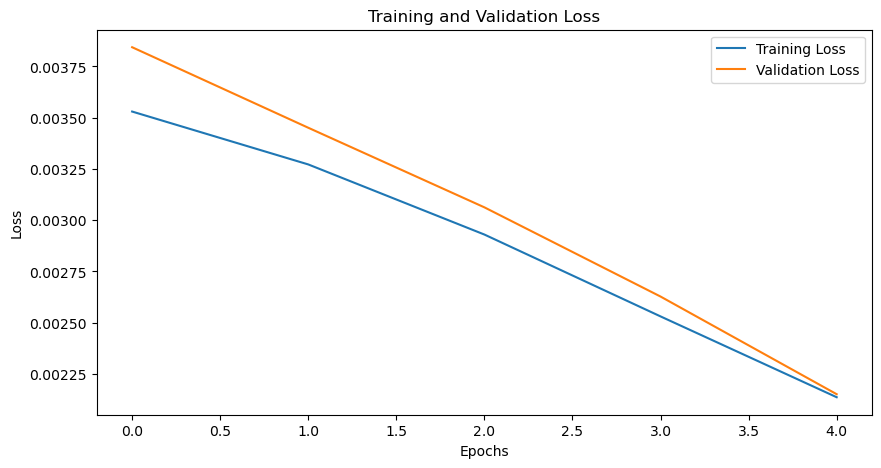

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Parameters
num_runs = 5
all_losses = []

# Simulate training multiple times
for i in range(num_runs):
    nn = NN_tensor(784, 300, 10, 0.001)   # Reinitialize the network to ensure random weights
    train = nn.train(X_train, t_train, epochs= 5, batch_size = 64)
    all_losses.append(train) 


all_losses


Epoch 0 Average Loss: 0.003703385634509207
Epoch 1 Average Loss: 0.003578606202786528
Epoch 2 Average Loss: 0.003374002559238217
Epoch 3 Average Loss: 0.002872491802058982
Epoch 4 Average Loss: 0.002039823252728084
Epoch 0 Average Loss: 0.003434269931691885
Epoch 1 Average Loss: 0.0030551550544079867
Epoch 2 Average Loss: 0.001992123124375358
Epoch 3 Average Loss: 0.0012186153715212427
Epoch 4 Average Loss: 0.0008368147956040754
Epoch 0 Average Loss: 0.0036077875518036873
Epoch 1 Average Loss: 0.0033756187058795197
Epoch 2 Average Loss: 0.0030384294460290237
Epoch 3 Average Loss: 0.0024587155640783264
Epoch 4 Average Loss: 0.0016950278092861763
Epoch 0 Average Loss: 0.002513415733145306
Epoch 1 Average Loss: 0.0020612633044522614
Epoch 2 Average Loss: 0.001701330332539603
Epoch 3 Average Loss: 0.001345956980693924
Epoch 4 Average Loss: 0.0009913814874007096
Epoch 0 Average Loss: 0.003698838265076062
Epoch 1 Average Loss: 0.003509975930940189
Epoch 2 Average Loss: 0.0032264940191047715


[[0.003703385634509207,
  0.003578606202786528,
  0.003374002559238217,
  0.002872491802058982,
  0.002039823252728084],
 [0.003434269931691885,
  0.0030551550544079867,
  0.001992123124375358,
  0.0012186153715212427,
  0.0008368147956040754],
 [0.0036077875518036873,
  0.0033756187058795197,
  0.0030384294460290237,
  0.0024587155640783264,
  0.0016950278092861763],
 [0.002513415733145306,
  0.0020612633044522614,
  0.001701330332539603,
  0.001345956980693924,
  0.0009913814874007096],
 [0.003698838265076062,
  0.003509975930940189,
  0.0032264940191047715,
  0.002802812289392105,
  0.002312649472884451]]

In [48]:
all_losses_array = np.array(all_losses)
mean_losses = np.mean(all_losses_array, axis=0)
std_losses = np.std(all_losses_array, axis=0)

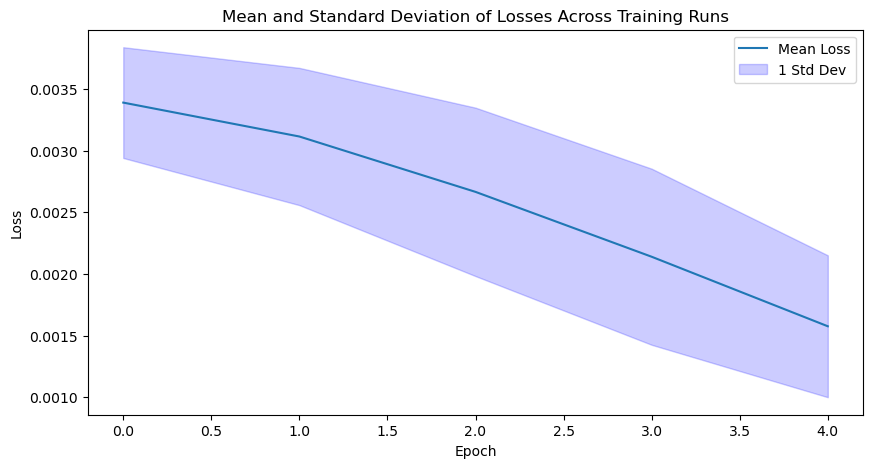

In [49]:
epochs = np.arange(len(mean_losses))

plt.figure(figsize=(10, 5))
plt.plot(epochs, mean_losses, label='Mean Loss')
plt.fill_between(epochs, mean_losses - std_losses, mean_losses + std_losses, color='b', alpha=0.2, label='1 Std Dev')
plt.title('Mean and Standard Deviation of Losses Across Training Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 0 Average Loss: 0.0037361508143338245
Epoch 1 Average Loss: 0.0033552785777303004
Epoch 2 Average Loss: 0.002214396699569701
Epoch 3 Average Loss: 0.0011537854106602134
Epoch 4 Average Loss: 0.0006041690101842061
Epoch 0 Average Loss: 0.0036937126980795694
Epoch 1 Average Loss: 0.0021823489100832975
Epoch 2 Average Loss: 0.0008119907740421583
Epoch 3 Average Loss: 0.00039659380808548973
Epoch 4 Average Loss: 0.00027506067426996136
Epoch 0 Average Loss: 0.001734110825734296
Epoch 1 Average Loss: 0.0003057462380466798
Epoch 2 Average Loss: 0.00029913826093626734
Epoch 3 Average Loss: 0.00038359194378096437
Epoch 4 Average Loss: 0.0006628353841470118
Epoch 0 Average Loss: 0.0007188368274121903
Epoch 1 Average Loss: 0.0006019556271631717
Epoch 2 Average Loss: 0.0011836239142009287
Epoch 3 Average Loss: 0.0019286909489997248
Epoch 4 Average Loss: 0.0024259600713736874


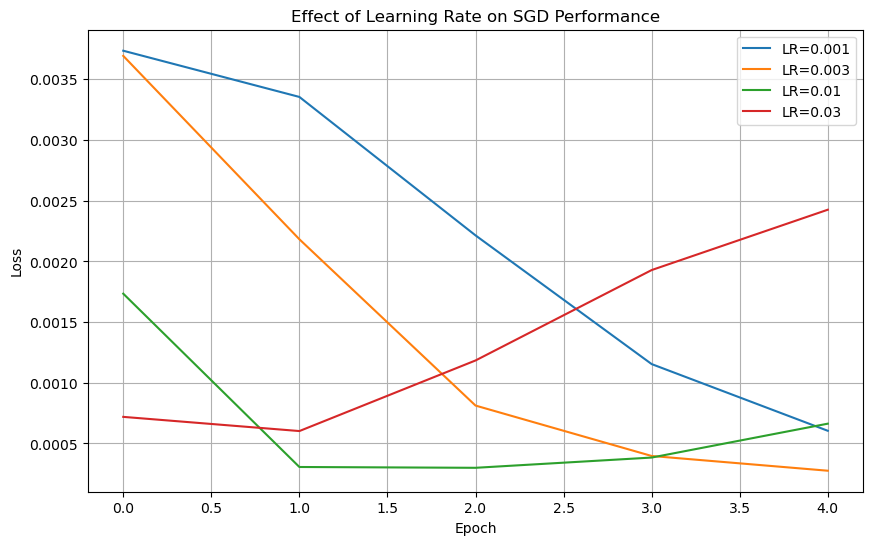

In [62]:
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()
# Normalize the pixel values
X_train = xtrain.astype('float32') / 255
X_val = xval.astype('float32') / 255
# Convert target value into one hot code
t_train = np.eye(10)[ytrain]
t_val = np.eye(10)[yval]

learning_rates = [0.001, 0.003, 0.01, 0.03]

plt.figure(figsize=(10, 6))
for lr in learning_rates:
    nn = NN_tensor(784, 300, 10, lr)   # Reinitialize the network to ensure random weights
    losses = nn.train(X_train, t_train, epochs= 5, batch_size = 64)
    plt.plot(losses, label=f'LR={lr}')

plt.title('Effect of Learning Rate on SGD Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
nn = NN_tensor(784, 300, 10, 0.003)
nn.train(X_train, t_train, epochs=5, batch_size = 64)

Epoch 0 Average Loss: 0.0030602974858741834
Epoch 1 Average Loss: 0.0020152709518952705
Epoch 2 Average Loss: 0.0013035157285834014
Epoch 3 Average Loss: 0.000719088952816096
Epoch 4 Average Loss: 0.0003720564388892451


[0.0030602974858741834,
 0.0020152709518952705,
 0.0013035157285834014,
 0.000719088952816096,
 0.0003720564388892451]

In [143]:
accuracy = nn.predict_and_accuracy(X_val, t_val)
accuracy

0.4746